# BERT Baseline

In [6]:
import pandas as pd
import numpy as np
import flair
from flair.data import Sentence
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random as rn
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# disable warnings
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = None
seed=40

# Import Amazon Reviews Dataset

In [9]:
rn.seed(a=40)
p = 0.01
review = pd.read_csv('data/raw/amazon_review.csv',skiprows=lambda i: i>0 and rn.random() > p)
review.shape

(5664, 10)

In [10]:
# 1 positive, 0 negative review
def score_round(x):
    if x>=3:
        return 1
    else: 
        return 0

In [11]:
review['review_score']= review.Score.apply(score_round)

In [12]:
review = review.rename(columns={'Text':'review_text'})

### Here i'm taking 80% of our data to be used as our model validation in case needed.

In [14]:
rn.seed(a=40)
q = 0.8 
review_val = pd.read_csv('data/raw/amazon_review.csv',skiprows=lambda i: i>0 and rn.random() > q)
review_val.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
2,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
3,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
4,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...


In [15]:
review_val['review_score']=review_val.Score.apply(score_round)

In [16]:
review_val = review_val.rename(columns={'Text':'review_text'})

In [17]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      5664 non-null   int64 
 1   ProductId               5664 non-null   object
 2   UserId                  5664 non-null   object
 3   ProfileName             5664 non-null   object
 4   HelpfulnessNumerator    5664 non-null   int64 
 5   HelpfulnessDenominator  5664 non-null   int64 
 6   Score                   5664 non-null   int64 
 7   Time                    5664 non-null   int64 
 8   Summary                 5664 non-null   object
 9   review_text             5664 non-null   object
 10  review_score            5664 non-null   int64 
dtypes: int64(6), object(5)
memory usage: 486.9+ KB


### Here i'm making sure that our text review data type is string

In [18]:
review.review_text = review.review_text.astype('str')
review_val.review_text = review.review_text.astype('str')

review.Summary = review.Summary.astype('str')
review_val.Summary = review.Summary.astype('str')

# 3. Analysis and Visualization

## 3.1. Distribution of Reviews in Each Sentiment

In [19]:
temp = review.groupby('review_score').count()['review_text'].reset_index().sort_values(by='review_text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,review_score,review_text
1,1,4837
0,0,827


### We will see the visualization of it.

<Axes: xlabel='review_score', ylabel='count'>

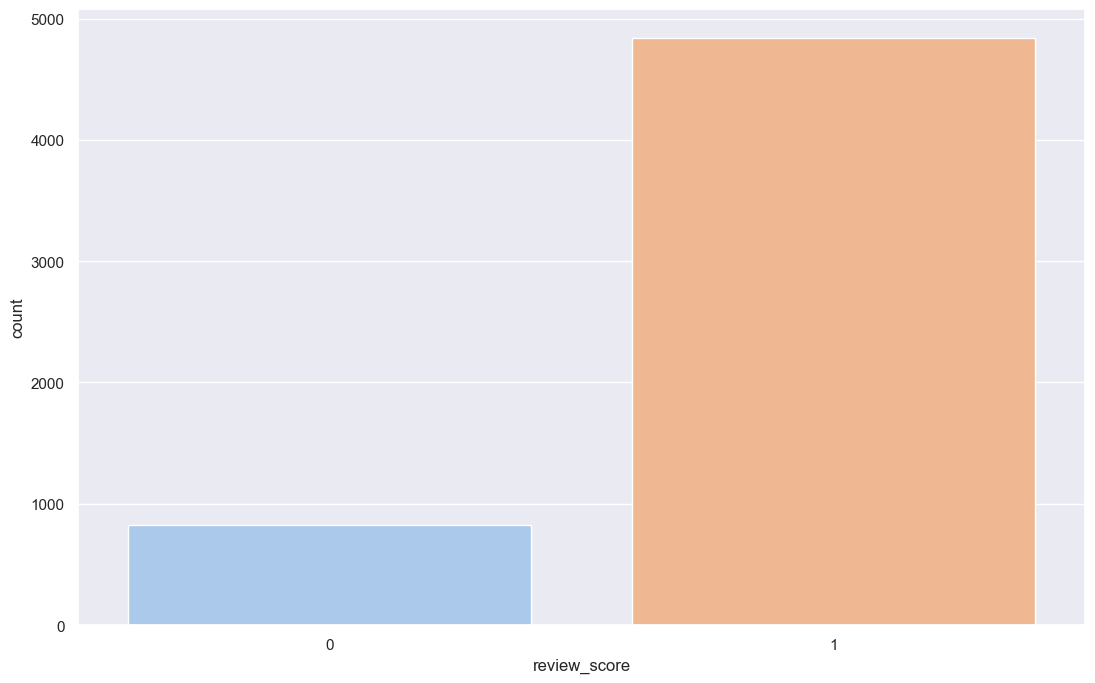

In [20]:
sns.set_theme(style='whitegrid')
sns.set(rc = {'figure.figsize':(13,8)})
sns.set_palette("pastel")
sns.countplot(x='review_score',data=review)

### We can see that there are more positive sentiment reviews than negative sentiment reviews.

## 3.2. WordCloud of Our Review Text

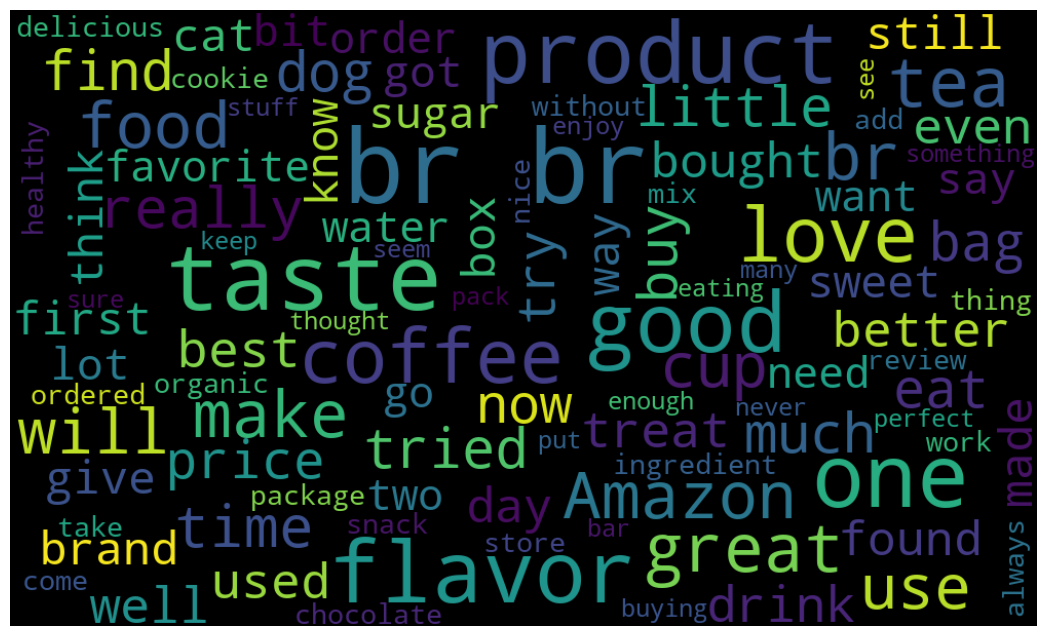

In [21]:
txt = ' '.join(rev for rev in review.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

## 3.3. WordCloud of Each Sentiment Review

In [22]:
positive = review[review['review_score']==1]
negative = review[review['review_score']==0]

## Positive Sentiment Text and Summary Reviews

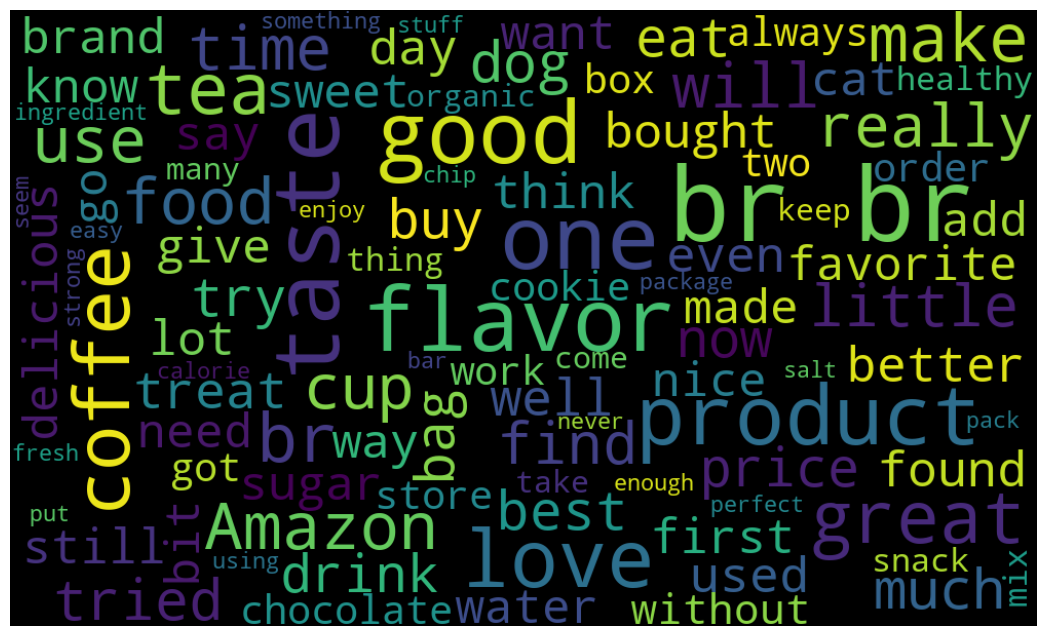

In [23]:
txt = ' '.join(rev for rev in positive.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

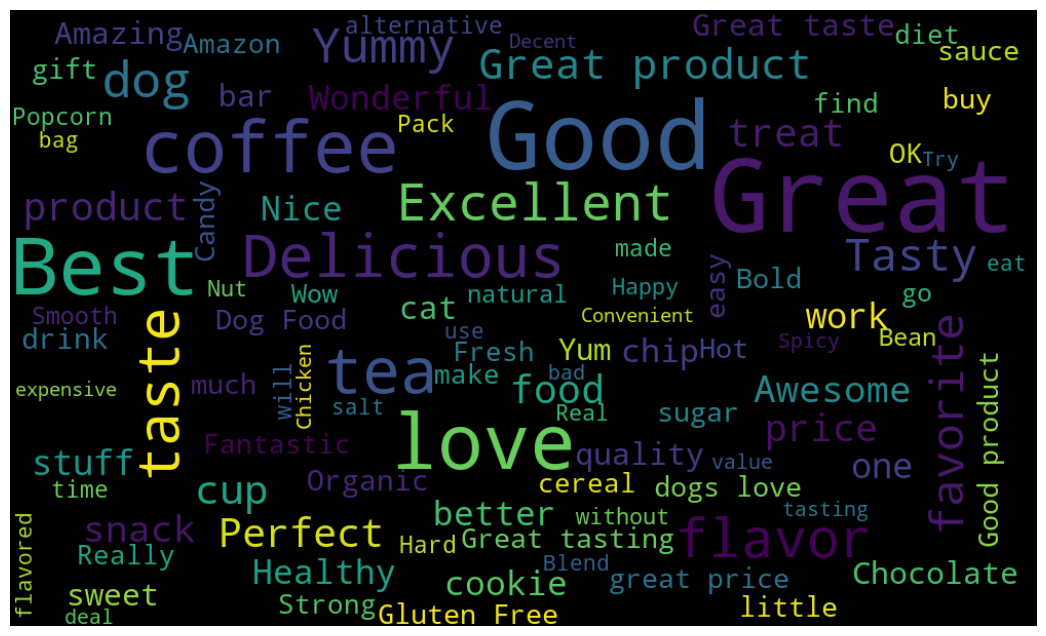

In [24]:
txt = ' '.join(rev for rev in positive.Summary)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

### We can see that for postive sentiment review, the most common words are 'good', 'tasty', 'great', 'love' , etc as shown in picture above.

## Negative Sentiment Reviews

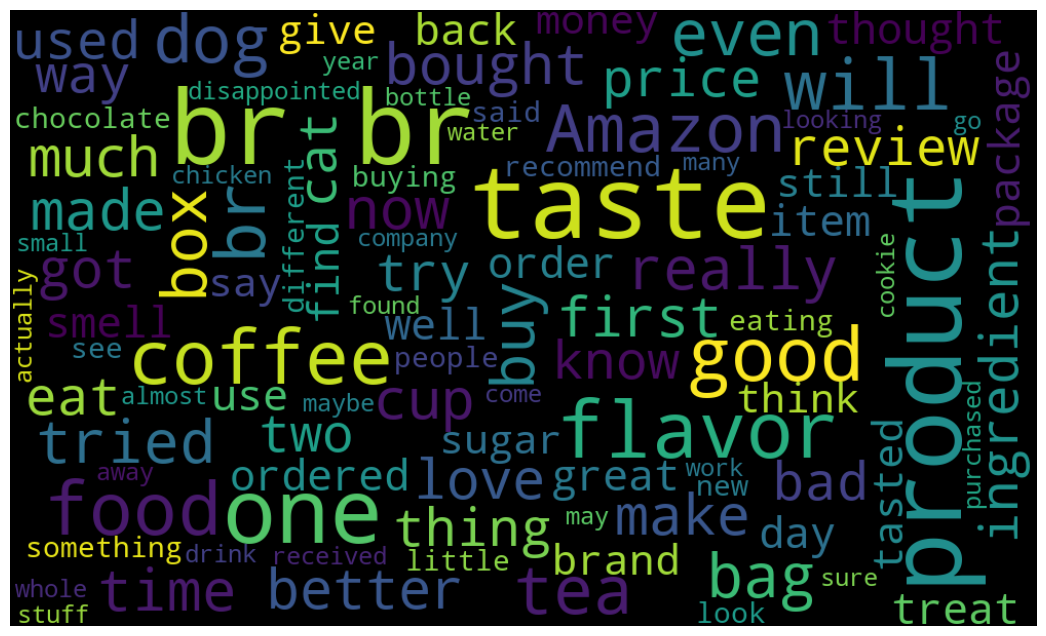

In [25]:
txt = ' '.join(rev for rev in negative.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

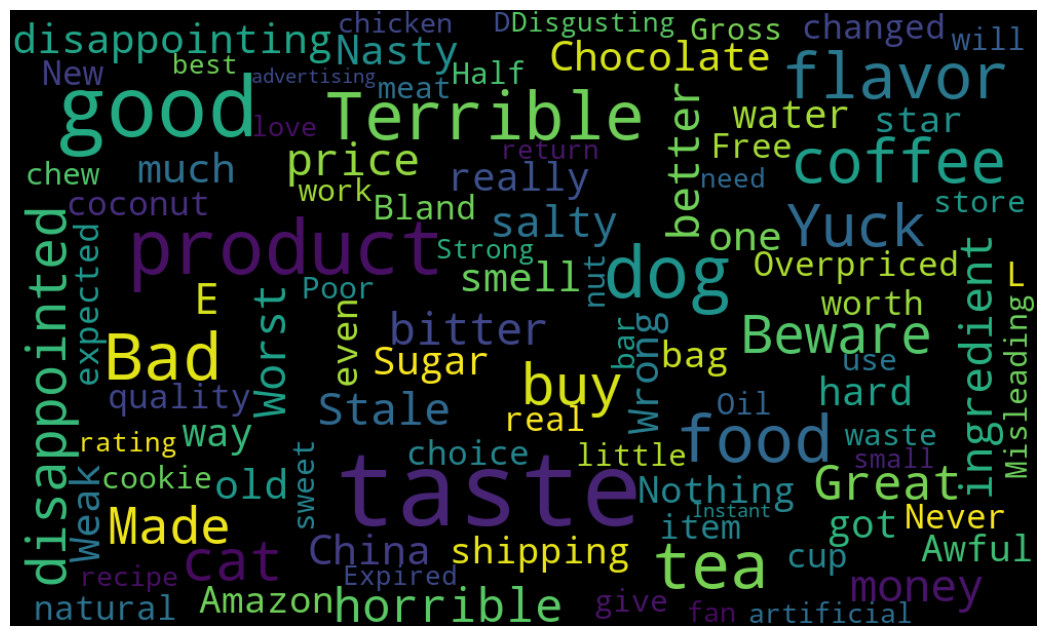

In [26]:
txt = ' '.join(rev for rev in negative.Summary)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

### And we can see that for negative sentiment review, the most common words are 'taste', 'disappointing', 'disappointed', 'Horrible', etc as shown in picture above.

## 3.4. Distribution of Number of Review Words

### First we create additional features to count number of words in each review text

In [27]:
review_vis = review.copy()

In [28]:
review_vis['Num_word_review'] = review_vis['review_text'].apply(lambda x:len(str(x).split()))

### Than we can plot them

<Axes: xlabel='Num_word_review', ylabel='Count'>

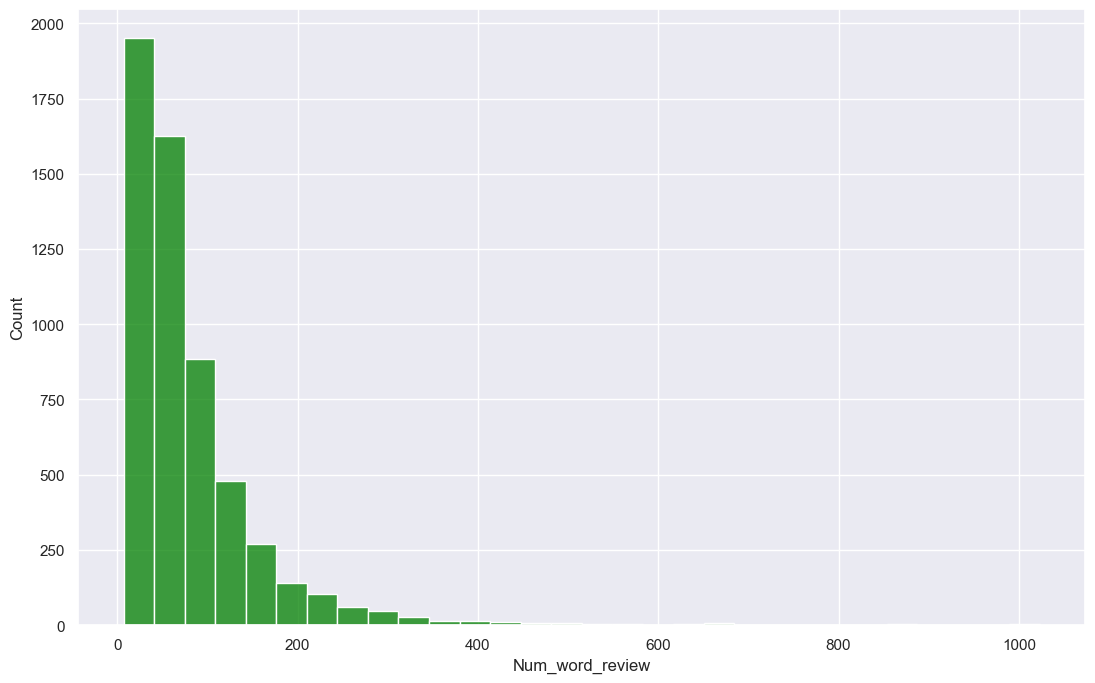

In [29]:
sns.histplot(data=review_vis, x="Num_word_review",bins=30,color='green')

### As we can see that most of our review texts contain 1-300 words.

## 3.5. Distribution of Words in All Review Texts

In [30]:
review_vis['temp_list'] = review_vis['review_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in review_vis['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,the,16381
1,I,13795
2,and,11859
3,a,11602
4,to,9647
5,of,7760
6,is,7163
7,it,6386
8,for,5222
9,in,4970


### Of course this list still contains stopwords which we have not filtered yet. We will see them later after we filter our review texts.

# 4. Data Cleaning For Sentiment Processing

from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('stopwords')
from nltk.stem import PorterStemmer

### Null values Cleaning

In [32]:
review.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
review_text               0
review_score              0
dtype: int64

### But after we've seen that the missing values are only in profile name feature, we will ignore them anyway.

### Duplicate Values Removing

In [33]:
review = review.drop_duplicates(keep='first')

In [34]:
review.shape

(5664, 11)

### We make a function to clean some basic characters

In [35]:
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

### We make function to remove numeric

In [36]:
def remove_num(texts):
   output = re.sub(r'\d+', '', texts)
   return output

### We make function to remove emoji

In [37]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

### We make function to unify whitespaces

In [38]:
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string 

### We make function to remove symbols

In [39]:
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
    return cleaned_string

### We make function to remove punctuation

In [40]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))
    return final

### We make function to remove stopwords

In [41]:
stop=set(stopwords.words("english"))
stemmer=PorterStemmer()
lemma=WordNetLemmatizer()

def remove_stopword(text):
   text=[word.lower() for word in text.split() if word.lower() not in stop]
   return " ".join(text)

### We make function to use stemming to normalize words

In [42]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
def Stemming(text):
   stem=[]
   stopword = stopwords.words('english')
   snowball_stemmer = SnowballStemmer('english')
   word_tokens = nltk.word_tokenize(text)
   stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
   stem=' '.join(stemmed_word)
   return stem

### Then we combine all the cleaning functions

In [43]:
def cleaning(df,review):
    df[review] = df[review].apply(clean)
    df[review] = df[review].apply(deEmojify)
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(remove_num)
    df[review] = df[review].apply(remove_symbols)
    df[review] = df[review].apply(remove_punctuation)
    df[review] = df[review].apply(remove_stopword)
    df[review] = df[review].apply(unify_whitespaces)

In [44]:
cleaning(review,'review_text')

In [45]:
review.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
review_text               0
review_score              0
dtype: int64

In [46]:
review[['review_text']].head(20)

,review_text
0,deal healthiest salt use box last family year ...
1,im learning latin american south american coff...
2,glad introduced brand sweetner replace sugar m...
3,think favorite cookies ever really light cream...
4,everyone family except one really likes taste ...
5,christmas eve tea actually contain tea christm...
6,terrific english triffle beware though pack co...
7,great thanks great service know else say said ...
8,love sorghum flour mild flavor smell easily mi...
9,best tasting stevia powder tried powders weird...


### Now all the cleanings are done. We will try to visualize the common words distribution of our review texts. We have done it before but our previous review texts still contain stopwords and punctuations.

In [47]:
review_vis2 = review.copy()

In [48]:
review_vis2['temp_list'] = review_vis2['review_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in review_vis2['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,br,6264
1,like,2591
2,good,2075
3,taste,1744
4,one,1721
5,coffee,1652
6,great,1629
7,product,1579
8,flavor,1578
9,tea,1515


# 5. BERT Tokenizing and Modelling

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tokenizers import BertWordPieceTokenizer

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

from collections import defaultdict

import logging
transformers.logging.set_verbosity_error()


In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## 5.1. We Split Our Data to Training, Test

In [51]:
reviews = review["review_text"].values.tolist()
labels = review["review_score"].tolist()

In [52]:
dict_label = {}

# 2 categories 1 and 0, count the number of each category
for i in labels:
    if i not in dict_label:
        dict_label[i] = 1
    else:
        dict_label[i] += 1
        
dict_label

{1: 4837, 0: 827}

In [53]:
training_sentences, validation_sentences, training_labels, validation_labels = train_test_split(reviews, labels, test_size=.4)

validation_sentences, test_sentences, validation_labels, test_labels = train_test_split(validation_sentences, validation_labels, test_size=.5)

## 5.2. We Tokenize Our Input Data

In [54]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [55]:
encoder_train = tokenizer.batch_encode_plus(training_sentences,
                                           add_special_tokens = True,
                                            return_attention_masks = True,
                                           pad_to_max_length = True,
                                           max_length = 256,
                                           return_tensors = 'pt')

encoder_val = tokenizer.batch_encode_plus(validation_sentences,
                                          add_special_tokens = True,
                                            return_attention_masks = True,
                                           pad_to_max_length = True,
                                           max_length = 256,
                                           return_tensors = 'pt')
                                          

encoder_test = tokenizer.batch_encode_plus(test_sentences,
                                           add_special_tokens = True,
                                            return_attention_masks = True,
                                           pad_to_max_length = True,
                                           max_length = 256,
                                           return_tensors = 'pt')

In [56]:
from torch.utils.data import TensorDataset

In [57]:
input_ids_train = encoder_train['input_ids']
attention_masks_train = encoder_train["attention_mask"]
labels_train = torch.tensor(training_labels)

input_ids_val = encoder_val['input_ids']
attention_masks_val = encoder_val["attention_mask"]
labels_val = torch.tensor(validation_labels)


input_ids_test = encoder_test['input_ids']
attention_masks_test = encoder_test["attention_mask"]
labels_test = torch.tensor(test_labels)

data_train = TensorDataset(input_ids_train,attention_masks_train,labels_train)
data_val = TensorDataset(input_ids_val,attention_masks_val,labels_val)
data_test = TensorDataset(input_ids_test,attention_masks_test,labels_test)

In [58]:
import random
from tqdm import tqdm
from transformers import AdamW,get_linear_schedule_with_warmup
from torch.utils.data import RandomSampler,SequentialSampler,DataLoader
from transformers import BertForSequenceClassification

In [59]:
dataloader_train = DataLoader(
    data_train,
    sampler= RandomSampler(data_train),
    batch_size = 16
    
)

dataloader_val = DataLoader(
    data_val,
    sampler= RandomSampler(data_val),
    batch_size = 16
)


dataloader_test = DataLoader(
    data_test,
    sampler= RandomSampler(data_test),
    batch_size = 32
    
)

## 5.3. BERT Model Fine-Tuning

In [60]:
model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME,
                                     num_labels = 2,
                                     output_attentions = False,
                                     output_hidden_states =  False).to(device)

In [61]:
optimizer = AdamW(model.parameters(),lr = 1e-5,eps = 1e-8)
epochs = 2
scheduler = get_linear_schedule_with_warmup(
            optimizer,
    num_warmup_steps = 0,
   num_training_steps = len(dataloader_train)*epochs 
)

In [62]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report

In [63]:
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [64]:
def flat_accuracy(preds,labels):
    pred_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat)/len(labels_flat)

In [65]:
def evaluate(model, dataloader_val, device):
    model.eval()
    
    loss_val_total = 0
    predictions,true_vals = [],[]

    accuracy_total = 0
    
    for batch in tqdm(dataloader_val):
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':  batch[0],
                  'attention_mask':batch[1],
                  'labels': batch[2]
                 }
        with torch.no_grad():
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total +=loss.item()
        
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        accracy = flat_accuracy(logits,label_ids)
        accuracy_total += accracy
        
    loss_val_avg = loss_val_total/len(dataloader_val)  
    accracy_avg = accuracy_total/len(dataloader_val)
    
    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0) 
    return loss_val_avg,accracy_avg,predictions,true_vals
            


In [66]:
def train_epoch(model, dataloader_train, dataloader_val, optimizer, scheduler, device, epoch, epochs):
    model.train()
    
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, desc="Epoch: {:1d}".format(epoch), leave=False, disable=False)
    
    for batch in progress_bar:
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            "input_ids": batch[0],
            "attention_mask": batch[1],
            "labels": batch[2]
        }
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
    
    tqdm.write('\nEpoch {}'.format(epoch))
    
    loss_train_avg = loss_train_total / len(dataloader_train)
    tqdm.write('Training Loss: {}'.format(loss_train_avg))
    
    val_loss, acc, _, _ = evaluate(model, dataloader_val, device)
    tqdm.write('Val Loss: {}\Val Accuracy: {}'.format(val_loss, acc))


In [ ]:
for epoch in range(1, epochs+1):
    train_epoch(model, dataloader_train, dataloader_val, optimizer, scheduler, device, epoch, epochs)


In [ ]:
# save model
import os
output_dir = './model_save/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model_to_save = model.module if hasattr(model,'module') else model
model_to_save.save_pretrained(output_dir)

In [ ]:
_, acc, predictions, true_vals = evaluate(model,dataloader_test,device)

100%|██████████| 71/71 [00:20<00:00,  3.54it/s]


In [ ]:
acc

0.8834981040086675

In [ ]:
print(classification_report(true_vals,np.argmax(predictions,axis=1)))

              precision    recall  f1-score   support

           0       0.63      0.48      0.54       328
           1       0.91      0.95      0.93      1938

    accuracy                           0.88      2266
   macro avg       0.77      0.71      0.74      2266
weighted avg       0.87      0.88      0.88      2266

